References:
- https://towardsdatascience.com/how-to-create-a-graph-neural-network-in-python-61fd9b83b54e
- https://www.youtube.com/watch?v=0YLZXjMHA-8&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=3
- https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/
- https://moleculenet.org/datasets-1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [2]:
# loading data
smiles = pd.read_csv("../../data/final/gnn_smiles_kpl.csv")
smiles_texpi = pd.read_csv("../../data/final/gnn_smiles_texpi_kpl.csv")

In [3]:
smiles

,SMILES,logkpl
0,C(=O)(N)N,-3.730000
1,C(C(C(C(C(CO)O)O)O)O)O,-4.354615
2,C(C(CO)O)O,-3.790000
3,C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O,-4.512857
4,C(C1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3(C(C(C(O3)CO)...,-4.575000
...,...,...
141,COC(=O)CC1=CC=C(C=C1)O,-1.700000
142,COC(C(C=O)O)C(C(CO)O)O,-3.680000
143,COC1=C(C=CC(=C1)CC=C)O,-1.575000
144,COS(=O)(=O)C,-1.990000


In [4]:
smiles_texpi

,SMILES,Texpi,logkpl
0,C(=O)(N)N,300,-3.690
1,C(=O)(N)N,310,-3.774
2,C(=O)(N)N,312,-3.550
3,C(C(C(C(C(CO)O)O)O)O)O,298,-3.970
4,C(C(C(C(C(CO)O)O)O)O)O,300,-4.190
...,...,...,...
217,COC(=O)CC1=CC=C(C=C1)O,310,-1.700
218,COC(C(C=O)O)C(C(CO)O)O,310,-3.680
219,COC1=C(C=CC(=C1)CC=C)O,305,-1.575
220,COS(=O)(=O)C,305,-1.990


In [7]:
# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

from functools import reduce
from torch_geometric.datasets import MoleculeNet
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

## Transforming the data from SMILES to Graphs

In [8]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

In [9]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [10]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [11]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [12]:
# canonical training loop for a Pytorch Geometric GNN model gnn_model

# create list of molecular graph objects from list of SMILES x_smiles and list of labels y
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smiles_log['SMILES'].values, smiles_log['logkpl'].values)

# create dataloader for training
dataloader = DataLoader(dataset = data_list, batch_size = 2**7)

c:\Users\user\anaconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [13]:
data_list

[Data(x=[4, 79], edge_index=[2, 6], edge_attr=[6, 10], y=[1]),
 Data(x=[12, 79], edge_index=[2, 22], edge_attr=[22, 10], y=[1]),
 Data(x=[6, 79], edge_index=[2, 10], edge_attr=[10, 10], y=[1]),
 Data(x=[23, 79], edge_index=[2, 48], edge_attr=[48, 10], y=[1]),
 Data(x=[34, 79], edge_index=[2, 72], edge_attr=[72, 10], y=[1]),
 Data(x=[9, 79], edge_index=[2, 18], edge_attr=[18, 10], y=[1]),
 Data(x=[10, 79], edge_index=[2, 20], edge_attr=[20, 10], y=[1]),
 Data(x=[9, 79], edge_index=[2, 18], edge_attr=[18, 10], y=[1]),
 Data(x=[9, 79], edge_index=[2, 18], edge_attr=[18, 10], y=[1]),
 Data(x=[9, 79], edge_index=[2, 18], edge_attr=[18, 10], y=[1]),
 Data(x=[14, 79], edge_index=[2, 28], edge_attr=[28, 10], y=[1]),
 Data(x=[11, 79], edge_index=[2, 22], edge_attr=[22, 10], y=[1]),
 Data(x=[9, 79], edge_index=[2, 18], edge_attr=[18, 10], y=[1]),
 Data(x=[11, 79], edge_index=[2, 22], edge_attr=[22, 10], y=[1]),
 Data(x=[13, 79], edge_index=[2, 26], edge_attr=[26, 10], y=[1]),
 Data(x=[8, 79], ed

In [14]:
# this is our input shape
data_list[0].x.shape[1]

79

In [15]:
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers # 79 is from len(data_list[0].x[0])
        # 79 is the shape of data_list[0].x.shape[1]
        # the shape of sparse matrix 
        self.initial_conv = GCNConv(data_list[0].x.shape[1], embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer 1 layer since it's a regression problem
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

In [16]:
model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(79, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  17729


In [17]:
# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
# Wrap data in a data loader
data_size = len(data_list)
NUM_GRAPHS_PER_BATCH = 16
loader = DataLoader(data_list[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data_list[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
       
      loss = torch.sqrt(loss_fn(pred, batch.y))       
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data_list)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 1.697835087776184


c:\Users\user\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\user\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100 | Train Loss 1.201999545097351
Epoch 200 | Train Loss 1.2159507274627686
Epoch 300 | Train Loss 1.2918668985366821
Epoch 400 | Train Loss 1.365828275680542
Epoch 500 | Train Loss 1.1008650064468384
Epoch 600 | Train Loss 1.3575019836425781
Epoch 700 | Train Loss 1.3900079727172852
Epoch 800 | Train Loss 1.2737929821014404
Epoch 900 | Train Loss 1.210620403289795
Epoch 1000 | Train Loss 1.5146998167037964
Epoch 1100 | Train Loss 1.0708576440811157
Epoch 1200 | Train Loss 1.1062391996383667
Epoch 1300 | Train Loss 0.8234751224517822
Epoch 1400 | Train Loss 1.735436201095581
Epoch 1500 | Train Loss 1.2540698051452637
Epoch 1600 | Train Loss 1.061004400253296
Epoch 1700 | Train Loss 1.2399587631225586
Epoch 1800 | Train Loss 1.0355032682418823
Epoch 1900 | Train Loss 0.8923667073249817


In [19]:
# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()

df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-1.600000,-2.422810
1,-2.870000,-2.418414
2,-0.850000,-2.335802
3,-1.440000,-2.387084
4,-3.680000,-2.571126
5,-2.520000,-2.445282
6,-2.460000,-2.451666
7,-3.295000,-2.380480
8,-3.133333,-2.496923
9,-2.250000,-2.489368


In [20]:

# Analyze the results for one batch
df = pd.DataFrame()
y_real = []
y_pred = []
for test_batch in test_loader:
    with torch.no_grad():
        test_batch.to(device)
        pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
        
        y_real.append(test_batch.y.tolist())
        y_pred.append(pred.tolist())

flatten_real_list = reduce(lambda z, y :z + y, y_real)
flatten_pred_list = reduce(lambda z, y :z + y, y_pred)


df['y_real'] = flatten_real_list
df['y_pred'] = flatten_pred_list
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-3.680000,-2.571126
1,-2.520000,-2.445282
2,-1.440000,-2.387084
3,-1.990000,-2.505542
4,-2.870000,-2.418414
5,-2.973333,-2.450828
6,-3.445714,-2.490537
7,-2.250000,-2.489368
8,-1.360000,-2.428213
9,-3.295000,-2.380480


In [27]:
# MAE, MSE, RMSE
print("MAE: {}".format(mean_absolute_error(df["y_real"], df["y_pred"])))
print("MSE: {}".format(mean_squared_error(df["y_real"], df["y_pred"])))
print("RMSE: {}".format(mean_squared_error(df["y_real"], df["y_pred"], squared=False)))
print("MAPE: {}".format(mean_absolute_percentage_error(df["y_real"], df["y_pred"])))
print("R2: {}".format(r2_score(df["y_real"], df["y_pred"])))

MAE: 0.6562893430391947
MSE: 0.5498570275597108
RMSE: 0.7415234504449005
MAPE: 0.33912662155203993
R2: 0.06883146183392586


In [30]:
# calculating R squared and Adjusted R squared
r_sqre = r2_score(df["y_real"], df["y_pred"])
n = df.shape[0]
p = 79 # number of independant features

Adj_r2 = 1 - ((1 - r_sqre) * (n - 1) / (n - 1 - p))
Adj_r2

1.5400777521363231

c:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

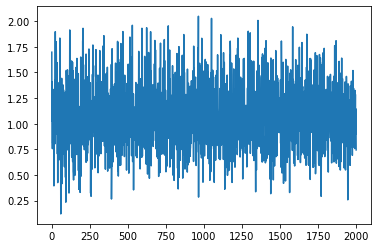

In [22]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

<AxesSubplot:xlabel='y_real', ylabel='y_pred'>

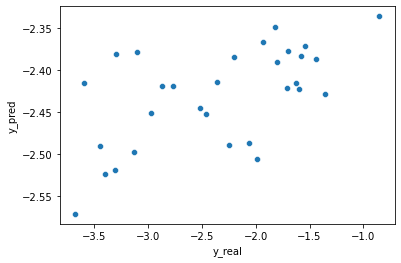

In [23]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt